In [1]:
import random
from time import time
import numpy as np

dart_ranges = np.logspace(1,7,15) # range of dart numbers over which to evaluate the parralleizations methods
dart_ranges = [int(el) for el in dart_ranges]

averages = 4 #number of times each simulation is run. 0rder(10^7) darts takes about 10-20s/average

First let us do a simple Monte Carlo simulation

In [2]:
#standard method

s_rt_all=[] #list to store the simple run times for each average
for j in range(averages): #loop over all averages
    simple_run_times = []  #list of run times for different number of darts
    for num_darts in dart_ranges: #loop over the number of darts in the simulation
        num_hits = 0 
        t0 = time()
        for i in range(num_darts):  #loop to calculate how often a dart lands within the area of a radius one circle
            x = random.uniform(-1,1)
            y = random.uniform(-1,1)
            if x**2+y**2<1:
                num_hits += 1
        tf = time()
        simple_run_times.append(tf-t0) #append run time to run time list
        if j == 0:  #print diagnostics (only on the first average)
            print("Number of Darts:",num_darts)
            print("Pi Approximations:",4*num_hits/num_darts)
            print("Fractional Error:",np.abs((4*num_hits/num_darts)-np.pi)/np.pi)   
            print("Run Time:",simple_run_times[-1],"s")
            print("Darts per Second:",num_darts/simple_run_times[-1],"\n")
    s_rt_all.append(simple_run_times)  #append list of run times to the super list to record averages
    print(j+1,"out of",averages,"rounds of simulations complete")

simple_mean = np.mean(s_rt_all,axis=0) #find average of all runs
simple_std = np.std(s_rt_all,axis=0) #find standard deviation of all runs
simple_darts_per_s = np.divide(dart_ranges,simple_mean) #find simulation rate


Number of Darts: 10
Pi Approximations: 3.2
Fractional Error: 0.0185916357881
Run Time: 3.3855438232421875e-05 s
Darts per Second: 295373.5211267606 

Number of Darts: 26
Pi Approximations: 3.6923076923076925
Fractional Error: 0.175298041294
Run Time: 5.2928924560546875e-05 s
Darts per Second: 491224.7927927928 

Number of Darts: 71
Pi Approximations: 3.211267605633803
Fractional Error: 0.022178226055
Run Time: 9.012222290039062e-05 s
Darts per Second: 787819.0052910052 

Number of Darts: 193
Pi Approximations: 3.0259067357512954
Fractional Error: 0.0368239713402
Run Time: 0.0002472400665283203 s
Darts per Second: 780617.81292189 

Number of Darts: 517
Pi Approximations: 3.1566731141199225
Fractional Error: 0.00480025967494
Run Time: 0.00066375732421875 s
Darts per Second: 778899.1264367816 

Number of Darts: 1389
Pi Approximations: 3.089992800575954
Fractional Error: 0.0164247433399
Run Time: 0.0017659664154052734 s
Darts per Second: 786538.1741595787 

Number of Darts: 3727
Pi Approxi

Now lets try parallelizing with Dask. The allows us to begin evaluation of a function without waiting for the result the asking for the result at the end.

In [3]:
import dask.array as da

#the strucutre of this simulation is roughly the same as for the simple Monte Carlo above

d_rt_all = []
for j in range(averages):
    dask_run_times = []
    for num_darts in dart_ranges:
        t0 = time()
        x = da.random.uniform(-1,1,size=(num_darts),chunks = (100000,)) #Load our random numbers (dart locations) into Dask arrays
        y = da.random.uniform(-1,1,size=(num_darts),chunks = (100000,))
        r = 1-(x**2 + y**2)//1  #find the radius of the the location and use integer division to convert it to a hit (1) or miss (0)
        num_hits = sum(r.compute())  #only now go look for the answer then sum it.
        dask_run_times.append(time()-t0)
        if j==0:  #print only on first average
            print("Number of Darts:",num_darts)
            print("Pi Approximations:",4*num_hits/num_darts)
            print("Fractional Error:",np.abs((4*num_hits/num_darts)-np.pi)/np.pi)   
            print("Run Time:",dask_run_times[-1],"s")
            print("Darts per Second:",num_darts/dask_run_times[-1],"\n")
    d_rt_all.append(dask_run_times)
    print(j+1,"out of",averages,"rounds of simulations complete")

dask_mean = np.mean(d_rt_all,axis=0)
dask_std = np.std(d_rt_all,axis=0)
dask_darts_per_s = np.divide(dart_ranges,dask_mean)

Number of Darts: 10
Pi Approximations: 2.4
Fractional Error: 0.236056273159
Run Time: 0.038236141204833984 s
Darts per Second: 261.5326673899759 

Number of Darts: 26
Pi Approximations: 2.92307692308
Fractional Error: 0.0695557173089
Run Time: 0.01918792724609375 s
Darts per Second: 1355.0186878727634 

Number of Darts: 71
Pi Approximations: 3.49295774648
Fractional Error: 0.111842982726
Run Time: 0.01454615592956543 s
Darts per Second: 4881.0146367048565 

Number of Darts: 193
Pi Approximations: 2.81865284974
Fractional Error: 0.102794932207
Run Time: 0.01595306396484375 s
Darts per Second: 12097.989478718317 

Number of Darts: 517
Pi Approximations: 3.05609284333
Fractional Error: 0.0272154348735
Run Time: 0.014862060546875 s
Darts per Second: 34786.56262833675 

Number of Darts: 1389
Pi Approximations: 3.10151187905
Fractional Error: 0.012758106782
Run Time: 0.014777183532714844 s
Darts per Second: 93996.2609874153 

Number of Darts: 3727
Pi Approximations: 3.11778910652
Fractional 

Lets do this simulation one more time with Multiprocessing. We'll use pools to allow the simulation to run over several processes which allows us to run calculations on multiple inputs at once

In [4]:
from multiprocessing import Pool

#again, this has the same rough structure as the functions above

mp_rt_all = []
for j in range(averages):
    mp_run_times = []

    def throw_dart(i): #a function to evaluate if a thrown dart is a hit or not
        x = random.uniform(-1,1)
        y = random.uniform(-1,1)
        return (1-int(x**2+y**2))

    for num_darts in dart_ranges:
        pool = Pool(processes=4) #initiate 4 processes
        t0 = time()
        result = list(pool.map(throw_dart,range(num_darts),chunksize=10000)) #map our inputs (the dart index) over our function using the pool as our processor
        num_hits = sum(result)
        mp_run_times.append(time()-t0)
        if j ==0: #print for first average
            print("Number of Darts:",num_darts)
            print("Pi Approximations:",4*num_hits/num_darts)
            print("Fractional Error:",np.abs((4*num_hits/num_darts)-np.pi)/np.pi)   
            print("Run Time:",mp_run_times[-1],"s")
            print("Darts per Second:",num_darts/mp_run_times[-1],"\n")
        pool.terminate() 
        del pool #remove pool once done using it
    
    mp_rt_all.append(mp_run_times)
    print(j+1,"out of",averages,"rounds of simulations complete")

mp_mean = np.mean(mp_rt_all,axis=0)
mp_std = np.std(mp_rt_all,axis=0)
mp_darts_per_s = np.divide(dart_ranges,mp_mean)

Number of Darts: 10
Pi Approximations: 3.6
Fractional Error: 0.145915590262
Run Time: 0.002727031707763672 s
Darts per Second: 3666.9907326455673 

Number of Darts: 26
Pi Approximations: 3.3846153846153846
Fractional Error: 0.0773565378528
Run Time: 0.0015420913696289062 s
Darts per Second: 16860.22016079159 

Number of Darts: 71
Pi Approximations: 2.9295774647887325
Fractional Error: 0.0674865306165
Run Time: 0.0016901493072509766 s
Darts per Second: 42008.12300747637 

Number of Darts: 193
Pi Approximations: 3.0259067357512954
Fractional Error: 0.0368239713402
Run Time: 0.0018630027770996094 s
Darts per Second: 103596.19554645508 

Number of Darts: 517
Pi Approximations: 3.148936170212766
Fractional Error: 0.00233751394045
Run Time: 0.002351999282836914 s
Darts per Second: 219812.99219462747 

Number of Darts: 1389
Pi Approximations: 3.1187904967602593
Fractional Error: 0.00725815194515
Run Time: 0.003771066665649414 s
Darts per Second: 368330.7995195043 

Number of Darts: 3727
Pi Ap

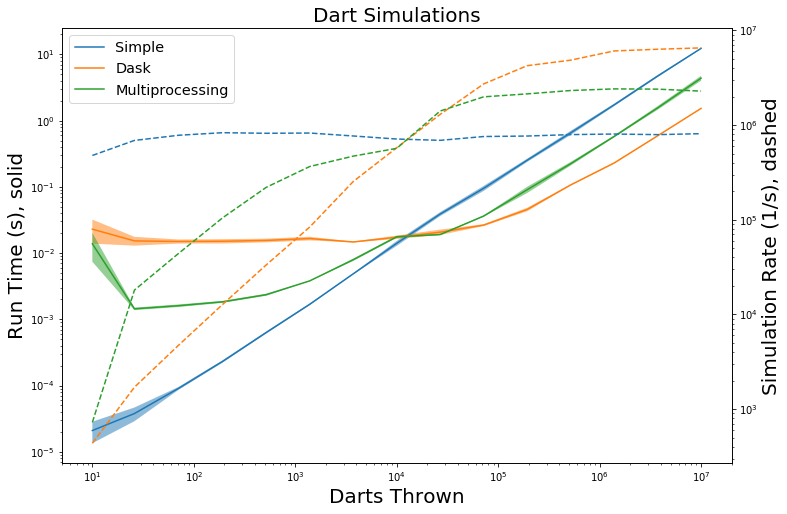

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.loglog(dart_ranges,simple_mean,label='Simple')
ax1.fill_between(dart_ranges,simple_mean+simple_std,simple_mean-simple_std,alpha=0.5)
ax1.loglog(dart_ranges,dask_mean,label='Dask')
ax1.fill_between(dart_ranges,dask_mean+dask_std,dask_mean-dask_std,alpha=0.5)
ax1.loglog(dart_ranges,mp_mean,label='Multiprocessing')
ax1.fill_between(dart_ranges,mp_mean+mp_std,mp_mean-mp_std,alpha=0.5)
ax2 = ax1.twinx()
ax2.loglog(dart_ranges,simple_darts_per_s,linestyle='--')
ax2.loglog(dart_ranges,dask_darts_per_s,linestyle='--')
ax2.loglog(dart_ranges,mp_darts_per_s,linestyle='--')
ax1.set_xlabel("Darts Thrown",fontsize = 20)
ax1.set_ylabel("Run Time (s), solid",fontsize = 20)
ax2.set_ylabel("Simulation Rate (1/s), dashed",fontsize = 20)
ax1.legend(fontsize='x-large')
plt.title("Dart Simulations",fontsize = 20)
plt.show()